## 2. Consuming data using Kafka (10%)


**Event Flight Consumer**

Write a python program that consumes the process events using kafka consumer, visualising the countFlightRecords in real time based on the timestamp. Save the file as Assignment-2B-Task2_flight_consumer.ipynb.

Your program should get the count of countFlightRecords captured by the consumer in the last 2-minutes (use the processing time) for each keyFlight. For this, print the number of flights for keyFlight = ‘1’, keyFlight = ‘2’, and keyFlight = ‘3’ only. Then, use line charts to visualize it. Note, in this task, please use ts as timestamp generated
from producer step (disregard DAY, DAY_OF_WEEK, MONTH, and YEAR as the real timestamp)


- Hint - x-axis can be used to represent the timestamp, while y-axis can be used to represent the number of countFlightRecords data can be represented in different color legends.

### Import libraries

In [1]:
# import statements
from time import sleep
from kafka import KafkaConsumer
import datetime as dt
import matplotlib
import matplotlib.pyplot as plt
from json import loads
import pandas as pd

# this line is needed for the inline display of graphs in Jupyter Notebook
%matplotlib notebook
topic = "flightTopic"

### Define the Kafka Connection

In [2]:
# Define the connection to Kafka Topic
def connect_kafka_consumer():
    _consumer = None
    try:
        _consumer = KafkaConsumer(
            topic,
            consumer_timeout_ms=10000,  # stop iteration if no message after 10 sec
            bootstrap_servers=["localhost:9092"],
            value_deserializer=lambda x: loads(x.decode("ascii")),
            api_version=(0, 10),
        )
    except Exception as ex:
        print("Exception while connecting Kafka")
        print(str(ex))
    finally:
        return _consumer

### Plot canvas initialisation 

In [3]:
# Initialisation of plot canvas
def init_plots():
    try:
        width = 12
        height = 7
        fig = plt.figure(figsize=(width, height))  # create new figure
        ax = fig.add_subplot(111)  # adding the subplot axes to the given grid position
        fig.suptitle(
            "Real-time Streaming Count of Day of Week "
        )  # giving figure a title
        ax.set_xlabel("Timestamp")
        ax.set_ylabel("Count")
        ax.set_ylim(0, 120)
        ax.set_yticks([0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110])
        fig.show()  # displaying the figure
        fig.canvas.draw()  # drawing on the canvas
        return fig, ax
    except Exception as ex:
        print(str(ex))

### Processing streamming data

In [4]:
# Prune the batch data to obtain aggreated length
def aggreateValues(msg):
    processeddf = (
        msg.loc[
            (msg["DAY_OF_WEEK"] == 1)
            | (msg["DAY_OF_WEEK"] == 2)
            | (msg["DAY_OF_WEEK"] == 3),
            ["DAY_OF_WEEK", "ts", "YEAR"],
        ]
        .groupby(["DAY_OF_WEEK", "ts"])
        .count()
        .reset_index()
        .rename(columns={"DAY_OF_WEEK": "DOW", "YEAR": "Count"})
    )
    return processeddf

In [5]:
# Preprocess the dataframe and obtain timestamp in hour,minute and seconds
def processData(item):
    pdata = item.pivot_table(
        values="Count",
        index=item["ts"].apply(
            lambda x: dt.datetime.fromtimestamp(x).strftime("%H:%M:%S")
        ),
        columns="DOW",
    )
    pdata = pdata.reset_index().dropna()
    pdata.columns = ["ts", "1", "2", "3"]

    return pdata

### Plotting Streamming data

In [6]:
# function to plot the graph
def plottingFun(plot_data, fig, ax):
    # define the x and y coordinates for the plot
    x = plot_data["ts"].tolist()
    y1 = plot_data["1"].tolist()
    y2 = plot_data["2"].tolist()
    y3 = plot_data["3"].tolist()
    # plot the line graph for each day of week
    ax.plot(x, y1, label="DOW=1")
    ax.plot(x, y2, label="DOW=2")
    ax.plot(x, y3, label="DOW=3")
    # Set graph label properties
    ax.set_xlabel("Timestamp")
    ax.set_ylabel("Count")
    # Set the axis properties
    plt.xticks(rotation=30)
    ax.set_ylim(0, 120)
    ax.set_yticks([i for i in range(0, 120, 10)])
    # legend and plot
    ax.legend(loc="lower right")
    fig.canvas.draw()
    return

### Consume Topic message from producer

In [7]:
# Function to consume the messages.
def consume_messages(consumer, fig, ax, thershold):
    try:
        # Define the COntainer for all Batch data
        countFlightRecords = pd.DataFrame()
        plot_data = pd.DataFrame()
        # set the current time
        currentTime = int(dt.datetime.now(dt.timezone.utc).timestamp())
        # first loop length
        first = True
        length = 0
        # define x and y
        x, y = [], []
        # Loop through to fetch data on each batch
        for message in consumer:
            # Receive the packet
            pkt = message.value
            # Receive the packet processing time.
            pkt_time = int(message.timestamp / 1000)
            # Fetch each batch data
            batch = aggreateValues(pd.DataFrame(message.value))
            # Contatinate packets into main datastore
            countFlightRecords = pd.concat([countFlightRecords, batch])
            # Aggreate the sum of Day of week and Timestamp
            countFlightRecords = (
                countFlightRecords.groupby(["DOW", "ts"]).sum().reset_index()
            )
            plot_data = processData(countFlightRecords)
            # Check if the processing time is in the 2 minute window
            if pkt_time <= (currentTime + thershold) and first == True:
                # clear the plot
                ax.clear()
                # plot the graph
                plottingFun(plot_data, fig, ax)
                # Calculate the length of plot_data to maintain 2 minute window
                length = len(plot_data["ts"])
            else:
                # once two minute window is elapsed set first to false
                first = False
                # calculate the records to be removed with addition of new timestamps
                size = len(plot_data["ts"]) - length
                # remove timestamp records
                plot_data.drop(plot_data.head(size).index, inplace=True)
                ax.clear()
                # plot the graph
                plottingFun(plot_data, fig, ax)
                # reassign length
                length = len(plot_data["ts"])
    except Exception as ex:
        print("Exception Occured!!")

### Main function

<IPython.core.display.Javascript object>


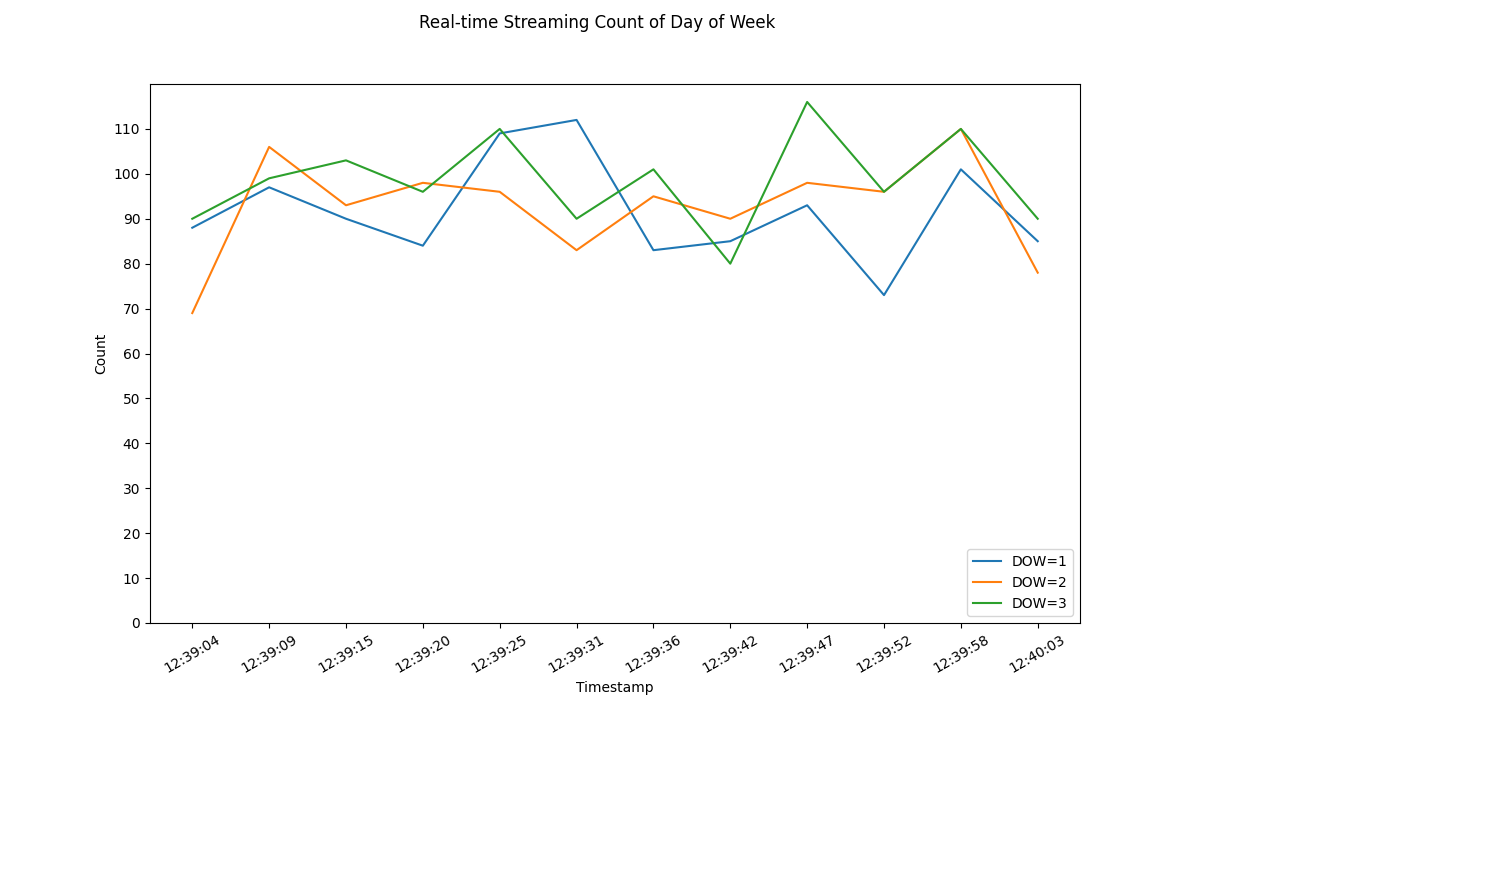

KeyboardInterrupt: 

In [8]:
if __name__ == "__main__":
    thershold = 60
    consumer = connect_kafka_consumer()
    fig, ax = init_plots()
    consume_messages(consumer, fig, ax, thershold)

### Reference
1. https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.legend.html
2. https://www.geeksforgeeks.org/matplotlib-pyplot-legend-in-python/
3. https://www.geeksforgeeks.org/python-pandas-dataframe-sort_index/
4. https://pandas.pydata.org/docs/reference/api/pandas.pivot_table.html
5. https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.set_index.html
6. https://stackoverflow.com/questions/43756052/transform-pandas-pivot-table-to-regular-dataframe
7. https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.drop.html
8. https://towardsdatascience.com/window-functions-in-pandas-eaece0421f7